In [ ]:
import pandas as pd
import numpy as np # Import numpy for .npy files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset from .npy files
try:
    # Assuming X.npy contains features and y.npy contains the target
    X_data_raw = np.load('X.npy', allow_pickle=True)
    y_data_raw = np.load('y.npy', allow_pickle=True)
    print("Dataset loaded successfully from .npy files.")
    print(f"X_data_raw shape: {X_data_raw.shape}")
    print(f"y_data_raw shape: {y_data_raw.shape}")
except FileNotFoundError:
    print("Error: 'X.npy' or 'y.npy' not found.")
    print("Please ensure the files are correctly uploaded or the path is correct.")
    exit()

# Identify target variable (consistent with previous runs)
target_column = 'Safety'

# The actual shape of X_data_raw is (912, 817).
# Assuming X_data_raw contains 7 categorical features followed by the rest as numerical features.
num_categorical_features = 7print all the
# Calculate numerical features based on the actual data shape
num_numerical_features = X_data_raw.shape[1] - num_categorical_features

# Create feature names for the DataFrame to ensure proper column handling by ColumnTransformer
cat_feature_names = [f'cat_feature_{i}' for i in range(num_categorical_features)]
num_feature_names = [f'num_feature_{i}' for i in range(num_numerical_features)]
all_feature_names = cat_feature_names + num_feature_names

# Convert NumPy arrays to pandas DataFrame/Series for easier handling and compatibility with existing code
X = pd.DataFrame(X_data_raw, columns=all_feature_names)
y = pd.Series(y_data_raw, name=target_column) # Assign the target_column name to the Series

print("\nFirst 5 rows of X:")
print(X.head())
print("\nFirst 5 rows of y:")
print(y.head())
print("\nDataFrame Info (X):")
X.info()
print("\nSeries Info (y):")
y.info()

# Identify categorical and numerical features explicitly based on the assumption
categorical_features = cat_feature_names
numerical_features = num_feature_names

print(f"\nIdentified Categorical Features ({len(categorical_features)}): {categorical_features}")
print(f"Identified Numerical Features ({len(numerical_features)}): {numerical_features}")

# Preprocessing for numerical and categorical features
# Create a column transformer for preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Ordinal encode the target variable
# Define the order of categories for 'model_safety'
# Assuming 0.0 < 1.0 < 2.0 for safety levels (Low, Medium, High)
# This order is crucial for interpreting some metrics, but for classification itself,
# as long as they are mapped consistently, it often works.
# For logistic regression, numerical encoding is needed.

# Check unique values in the target column to define correct order
unique_safety_levels = y.unique()
print(f"\nUnique '{target_column}' levels: {unique_safety_levels}")

# Define the order of categories based on observed numerical values
# Assuming 0.0 is 'Low', 1.0 is 'Medium', 2.0 is 'High'
safety_order = sorted(unique_safety_levels)

# Filter safety_order to only include levels present in the data
# This makes the encoder robust to missing levels in the predefined order
filtered_safety_order = [level for level in safety_order if level in unique_safety_levels]

if not filtered_safety_order:
    print(f"Error: None of the assumed safety levels ({safety_order}) found in the target column.")
    print(f"Please verify the values in the '{target_column}' column and the expected order.")
    exit()

# Remove classes with only one sample to avoid ValueError in train_test_split with stratify
class_counts = y.value_counts()
classes_to_keep = class_counts[class_counts >= 2].index

if len(classes_to_keep) < len(unique_safety_levels):
    removed_classes = set(unique_safety_levels) - set(classes_to_keep)
    print(f"Warning: Removing data points belonging to classes with less than 2 samples: {list(removed_classes)}")
    X = X[y.isin(classes_to_keep)]
    y = y[y.isin(classes_to_keep)]

# Re-check unique levels and update filtered_safety_order after removal
unique_safety_levels_after_filter = y.unique()
filtered_safety_order = sorted([level for level in safety_order if level in unique_safety_levels_after_filter])

print(f"Using target order: {filtered_safety_order}")

# Create and fit the OrdinalEncoder for the target variable
y_encoder = OrdinalEncoder(categories=[filtered_safety_order], dtype=int)
y_encoded = y_encoder.fit_transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Create a pipeline with preprocessing and Decision Tree Classifier model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42)) # Changed to Decision Tree Classifier
])

# Train the model
print("\nTraining Decision Tree Classifier model...") # Updated print statement
model_pipeline.fit(X_train, y_train.ravel())
print("Model training complete.")

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=[str(level) for level in filtered_safety_order])

print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# Display the actual vs predicted for a few samples
results_df = pd.DataFrame({'Actual': y_encoder.inverse_transform(y_test).ravel(),
                           'Predicted': y_encoder.inverse_transform(y_pred.reshape(-1, 1)).ravel()})
print("\nSample of Actual vs Predicted:")
print(results_df.head(10))

Dataset loaded successfully from .npy files.
X_data_raw shape: (912, 817)
y_data_raw shape: (912,)

First 5 rows of X:
   cat_feature_0  cat_feature_1  cat_feature_2  cat_feature_3  cat_feature_4  \
0       0.491731       0.445704       0.536442       0.337588       0.312587   
1       0.485678       0.530327       0.436576       0.362194       0.236883   
2       0.503587       0.503648       0.495329       0.454812       0.436726   
3       0.513355       0.506937       0.520861       0.428034       0.364365   
4       0.508415       0.506770       0.551365       0.616755       0.669093   

   cat_feature_5  cat_feature_6  num_feature_0  num_feature_1  num_feature_2  \
0       0.293664       0.385367       0.252270       0.308534       0.444599   
1       0.213763       0.298091       0.220172       0.236897       0.449872   
2       0.450115       0.462686       0.467707       0.441645       0.410032   
3       0.360623       0.441920       0.361150       0.355209       0.419322   


In [ ]:
y_train_pred = model_pipeline.predict(X_train)
y_train_proba = model_pipeline.predict_proba(X_train)
y_test_pred = model_pipeline.predict(X_test)
y_test_proba = model_pipeline.predict_proba(X_test)

print("Predictions generated for training and testing sets.")

Predictions generated for training and testing sets.


In [ ]:
import numpy as np

# Find the ccp_alpha that maximizes the test accuracy
optimal_alpha_index = np.argmax(test_scores)
optimal_ccp_alpha = ccp_alphas[optimal_alpha_index]
max_test_accuracy = test_scores[optimal_alpha_index]

print(f"The optimal ccp_alpha for maximum test accuracy is: {optimal_ccp_alpha:.6f}")
print(f"Maximum test accuracy achieved with this alpha: {max_test_accuracy:.4f}")

# Retrain the model with the optimal ccp_alpha
pruned_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_ccp_alpha))
])

print(f"\nTraining pruned Decision Tree Classifier with ccp_alpha={optimal_ccp_alpha:.6f}...")
pruned_model_pipeline.fit(X_train, y_train.ravel())
print("Pruned model training complete.")

# Make predictions on the test set with the pruned model
y_pred_pruned = pruned_model_pipeline.predict(X_test)

# Evaluate the pruned model
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
report_pruned = classification_report(y_test, y_pred_pruned, target_names=[str(level) for level in filtered_safety_order])

print(f"\nPruned Model Accuracy: {accuracy_pruned:.4f}")
print("\nPruned Classification Report:")
print(report_pruned)

# Display the actual vs predicted for a few samples for the pruned model
results_df_pruned = pd.DataFrame({'Actual': y_encoder.inverse_transform(y_test).ravel(),
                                  'Predicted': y_encoder.inverse_transform(y_pred_pruned.reshape(-1, 1)).ravel()})
print("\nSample of Actual vs Predicted (Pruned Model):")
print(results_df_pruned.head(10))

# Compare with the original model's accuracy
print(f"\nOriginal Model Accuracy: {accuracy:.4f}")

The optimal ccp_alpha for maximum test accuracy is: 0.004658
Maximum test accuracy achieved with this alpha: 0.8634

Training pruned Decision Tree Classifier with ccp_alpha=0.004658...
Pruned model training complete.

Pruned Model Accuracy: 0.8634

Pruned Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90        47
         1.0       0.69      0.74      0.72        39
         2.0       0.94      0.88      0.91        97

    accuracy                           0.86       183
   macro avg       0.83      0.85      0.84       183
weighted avg       0.87      0.86      0.87       183


Sample of Actual vs Predicted (Pruned Model):
   Actual  Predicted
0     1.0        0.0
1     2.0        2.0
2     2.0        2.0
3     2.0        1.0
4     0.0        0.0
5     1.0        1.0
6     1.0        1.0
7     2.0        2.0
8     0.0        0.0
9     2.0        0.0

Original Model Accuracy: 0.8033


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Extract the Decision Tree Classifier from the pipeline
decision_tree_model = model_pipeline.named_steps['classifier']

# Get the ccp_alpha values and their corresponding impurities
path = decision_tree_model.cost_complexity_pruning_path(model_pipeline.named_steps['preprocessor'].fit_transform(X_train), y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(f"Number of ccp_alphas found: {len(ccp_alphas)}")
print(f"First 5 ccp_alphas: {ccp_alphas[:5]}")

Number of ccp_alphas found: 53
First 5 ccp_alphas: [0.         0.00137174 0.00137174 0.00182899 0.00182899]


In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    temp_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha))
    ])
    temp_pipeline.fit(X_train, y_train.ravel())
    clfs.append(temp_pipeline)

print(f"Trained {len(clfs)} decision trees with different ccp_alphas.")

Trained 53 decision trees with different ccp_alphas.


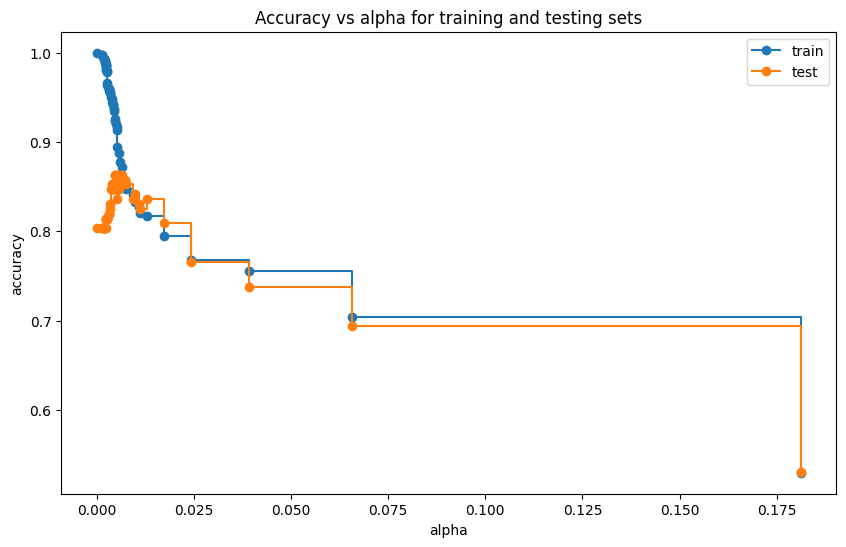

Plot of accuracy vs. ccp_alpha generated.


In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

print("Plot of accuracy vs. ccp_alpha generated.")

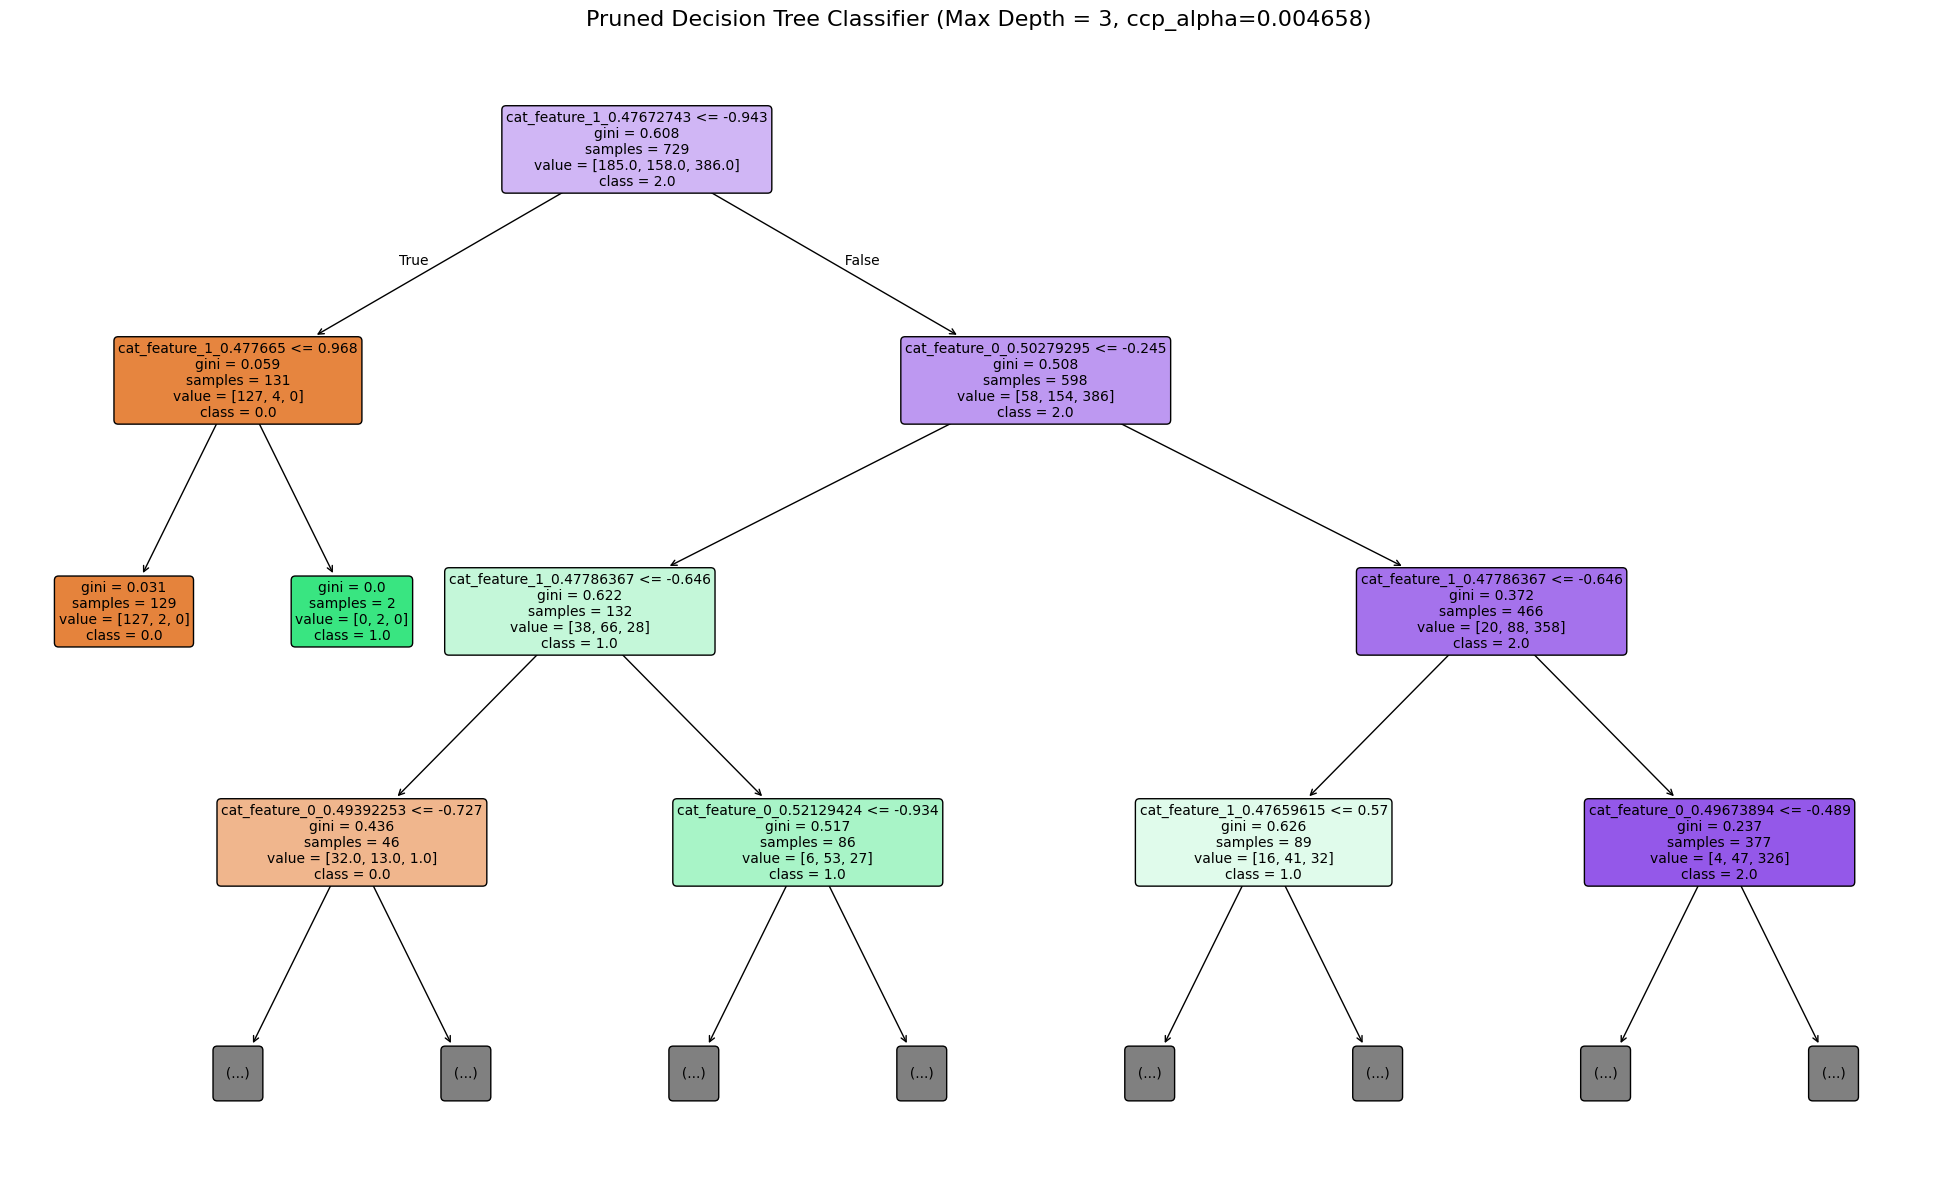

Pruned Decision tree visualized with max_depth=3.


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the Pruned Decision Tree Classifier from the pipeline
pruned_decision_tree_model = pruned_model_pipeline.named_steps['classifier']

# Reuse feature names after preprocessing from the previous visualization step
# onehot_encoder = pruned_model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
# encoded_feature_names = onehot_encoder.get_feature_names_out(categorical_features)
# all_processed_feature_names = list(encoded_feature_names) + numerical_features
# (all_processed_feature_names and filtered_safety_order are already available from previous cells)

# Plot the pruned decision tree
plt.figure(figsize=(25, 15))
plot_tree(pruned_decision_tree_model,
          feature_names=all_processed_feature_names,
          class_names=[str(level) for level in filtered_safety_order],
          filled=True,
          rounded=True,
          max_depth=3, # Limit depth for better visualization
          fontsize=10)
plt.title(f'Pruned Decision Tree Classifier (Max Depth = 3, ccp_alpha={optimal_ccp_alpha:.6f})', fontsize=16)
plt.show()

print("Pruned Decision tree visualized with max_depth=3.")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print("Libraries imported successfully for ROC curve plotting and AUC calculation.")

Libraries imported successfully for ROC curve plotting and AUC calculation.


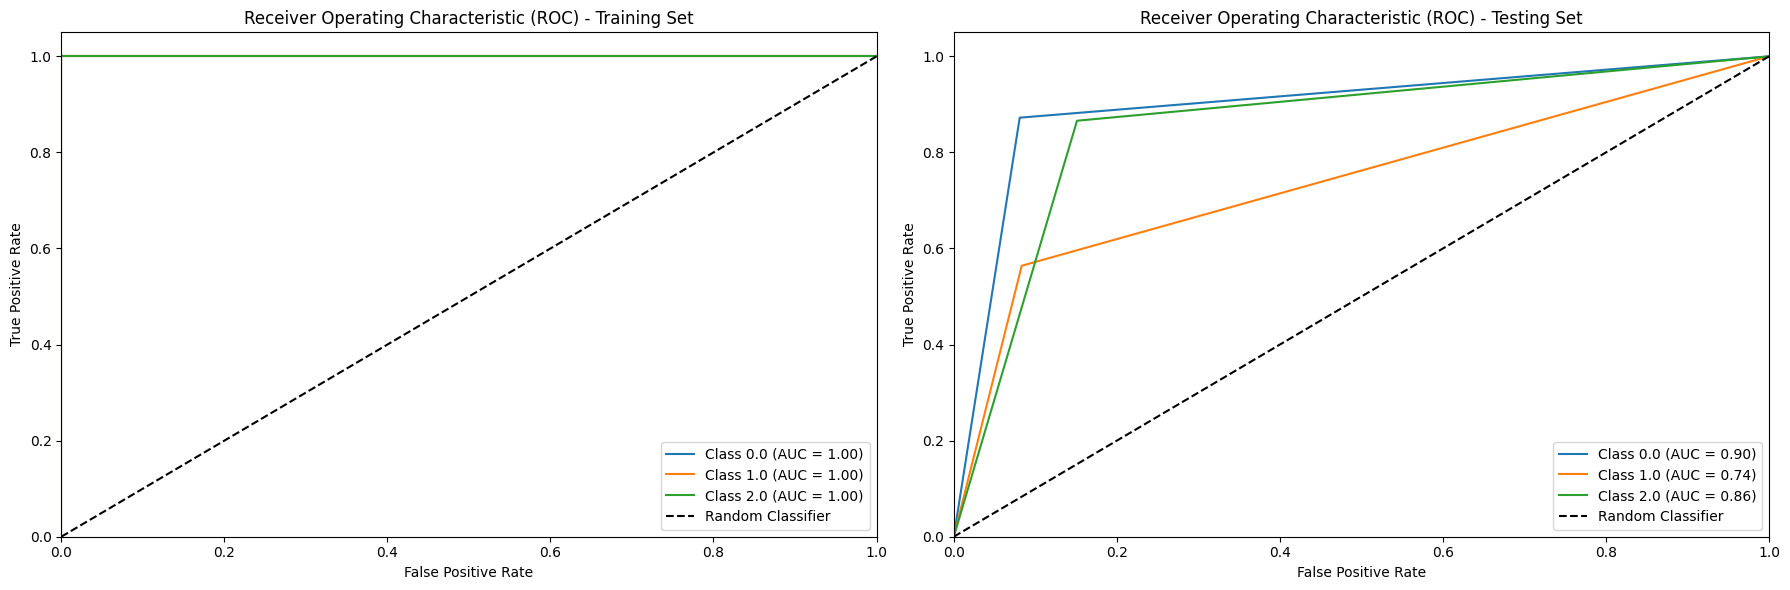

ROC curves and AUC scores plotted for training and testing sets.


In [ ]:
n_classes = len(filtered_safety_order)
class_labels = [str(level) for level in filtered_safety_order]

# Prepare figure for plotting
plt.figure(figsize=(18, 6))

# Plot ROC for Training Set
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
for i in range(n_classes):
    y_train_true_class = (y_train == i).astype(int) # True labels for current class
    fpr, tpr, _ = roc_curve(y_train_true_class, y_train_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Set')
plt.legend(loc='lower right')

# Plot ROC for Testing Set
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
for i in range(n_classes):
    y_test_true_class = (y_test == i).astype(int) # True labels for current class
    fpr, tpr, _ = roc_curve(y_test_true_class, y_test_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Testing Set')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

print("ROC curves and AUC scores plotted for training and testing sets.")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

print("ConfusionMatrixDisplay imported successfully.")

ConfusionMatrixDisplay imported successfully.


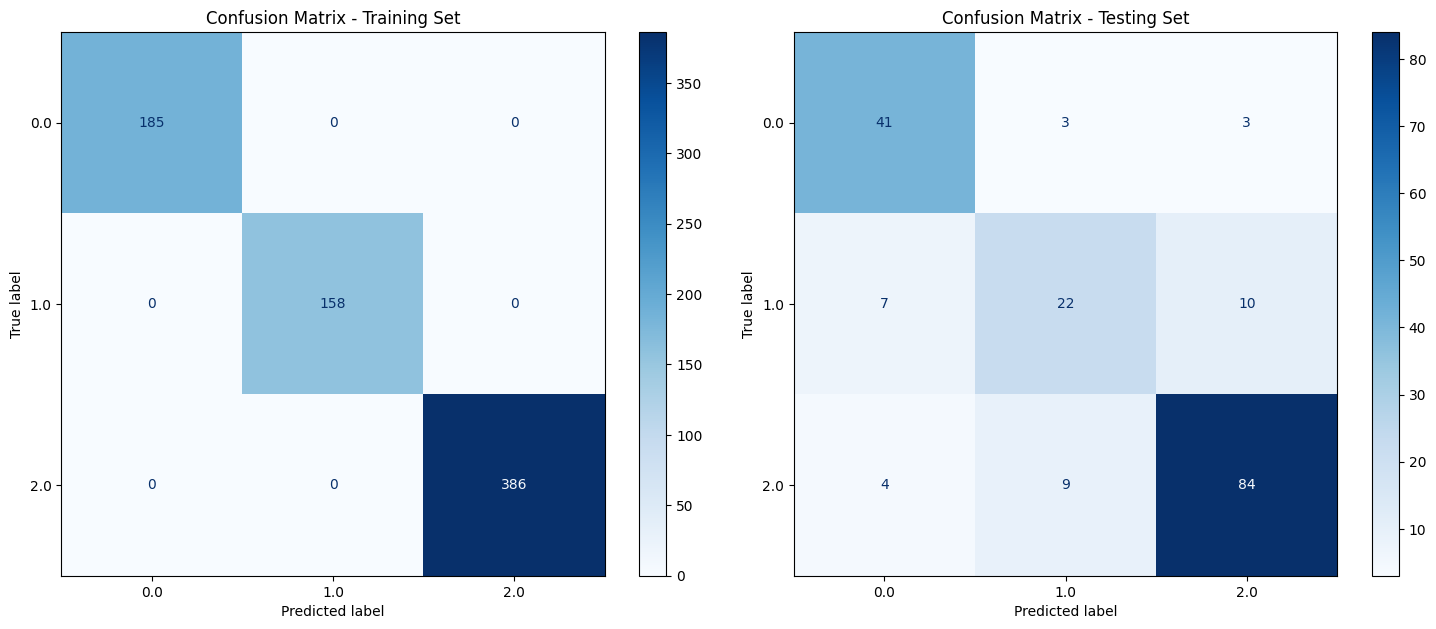

Confusion matrices plotted for training and testing sets.


In [ ]:
plt.figure(figsize=(15, 6))

# Plot Confusion Matrix for Training Set
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=class_labels, cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix - Training Set')

# Plot Confusion Matrix for Testing Set
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=class_labels, cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix - Testing Set')

plt.tight_layout()
plt.show()

print("Confusion matrices plotted for training and testing sets.")

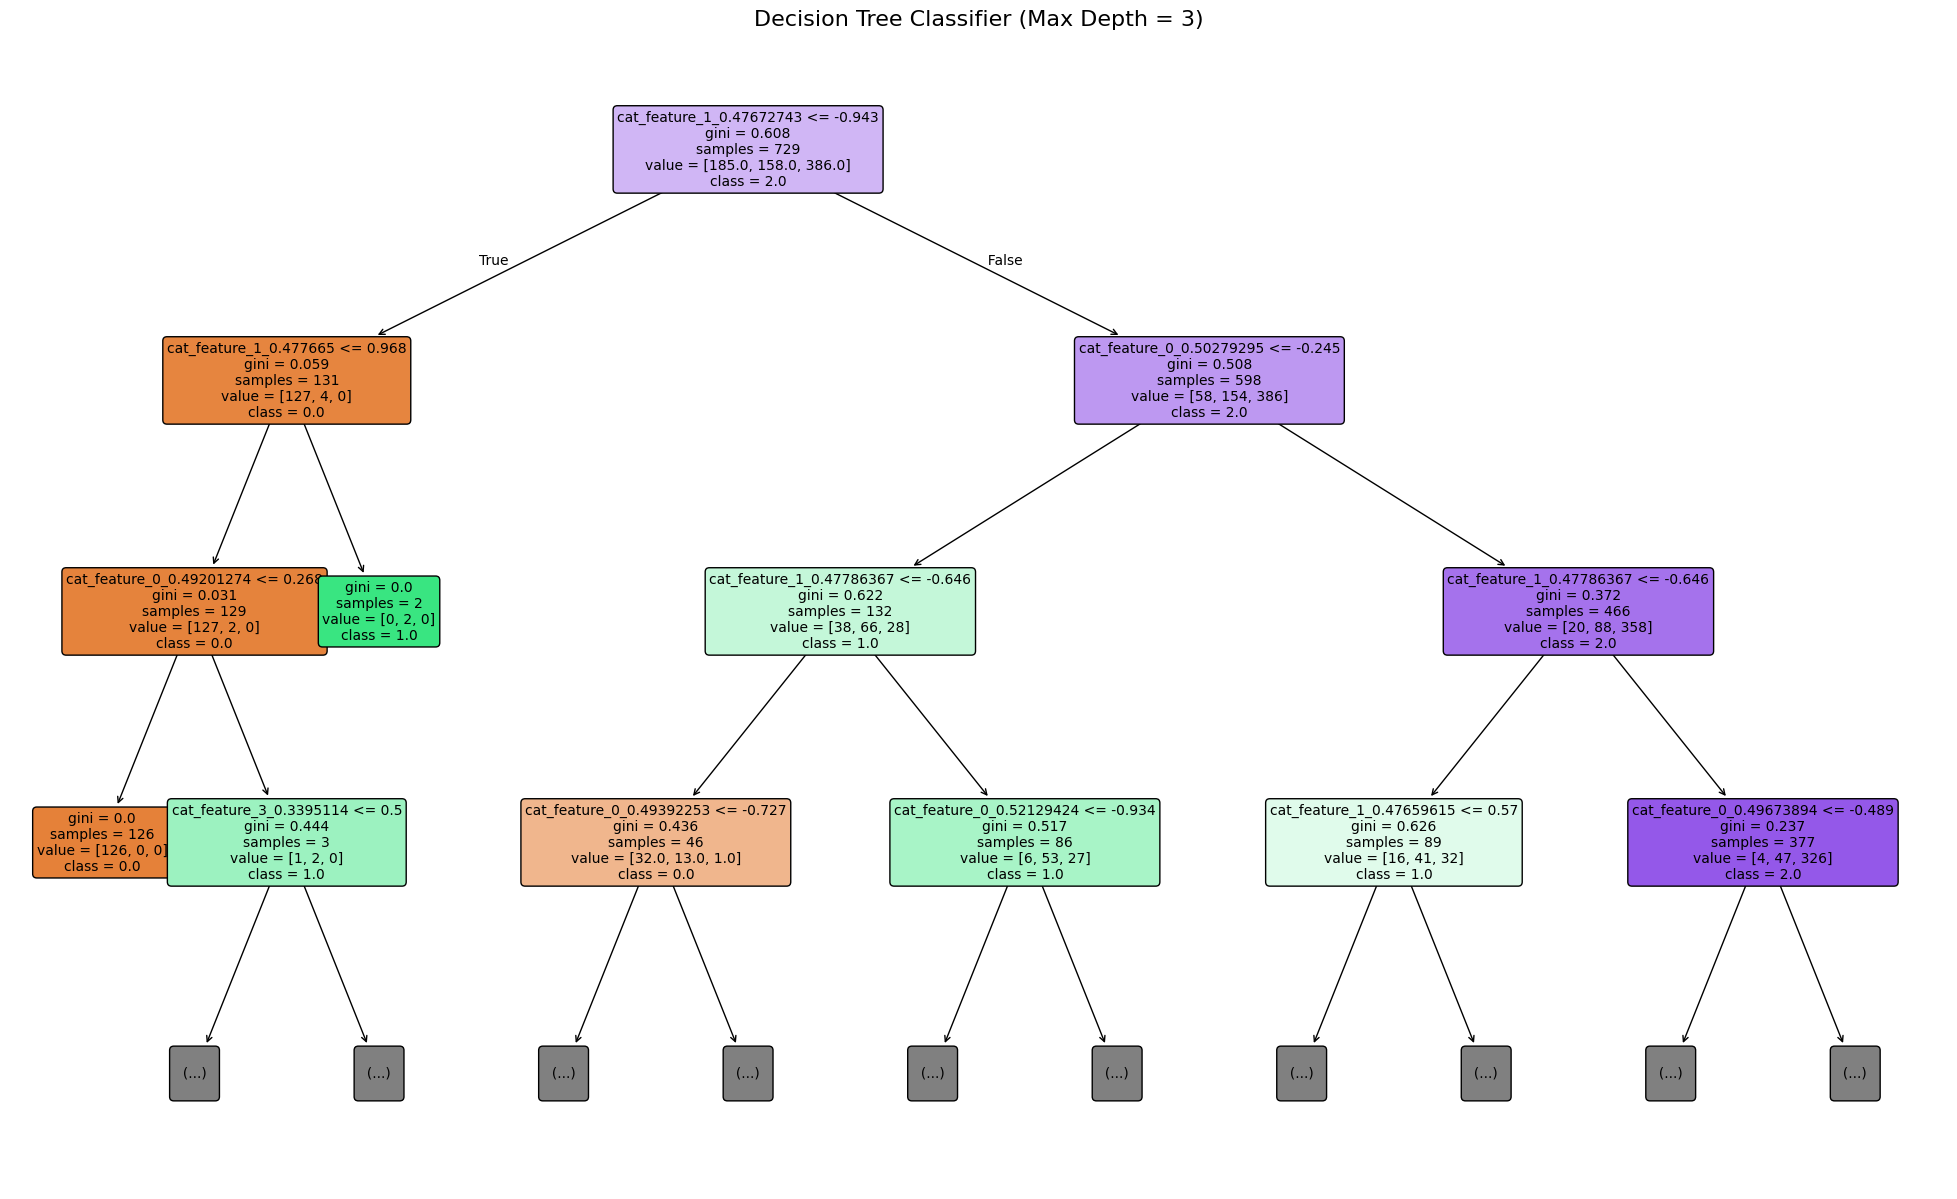

Decision tree visualized with max_depth=3.


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the Decision Tree Classifier from the pipeline
decision_tree_model = model_pipeline.named_steps['classifier']

# Get feature names after preprocessing
# This involves getting the one-hot encoded feature names and original numerical feature names
onehot_encoder = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_feature_names = onehot_encoder.get_feature_names_out(categorical_features)
all_processed_feature_names = list(encoded_feature_names) + numerical_features

# Plot the decision tree
plt.figure(figsize=(25, 15))
plot_tree(decision_tree_model,
          feature_names=all_processed_feature_names,
          class_names=[str(level) for level in filtered_safety_order],
          filled=True,
          rounded=True,
          max_depth=3, # Limit depth for better visualization
          fontsize=10)
plt.title('Decision Tree Classifier (Max Depth = 3)', fontsize=16)
plt.show()

print("Decision tree visualized with max_depth=3.")

In [ ]:
print(f"Depth of the decision tree: {decision_tree_model.tree_.max_depth}")

Depth of the decision tree: 19


In [ ]:
y_train_pred_pruned = pruned_model_pipeline.predict(X_train)
y_train_proba_pruned = pruned_model_pipeline.predict_proba(X_train)
y_test_pred_pruned = pruned_model_pipeline.predict(X_test)
y_test_proba_pruned = pruned_model_pipeline.predict_proba(X_test)

print("Predictions (class and probability) generated for training and testing sets using the pruned model.")

Predictions (class and probability) generated for training and testing sets using the pruned model.


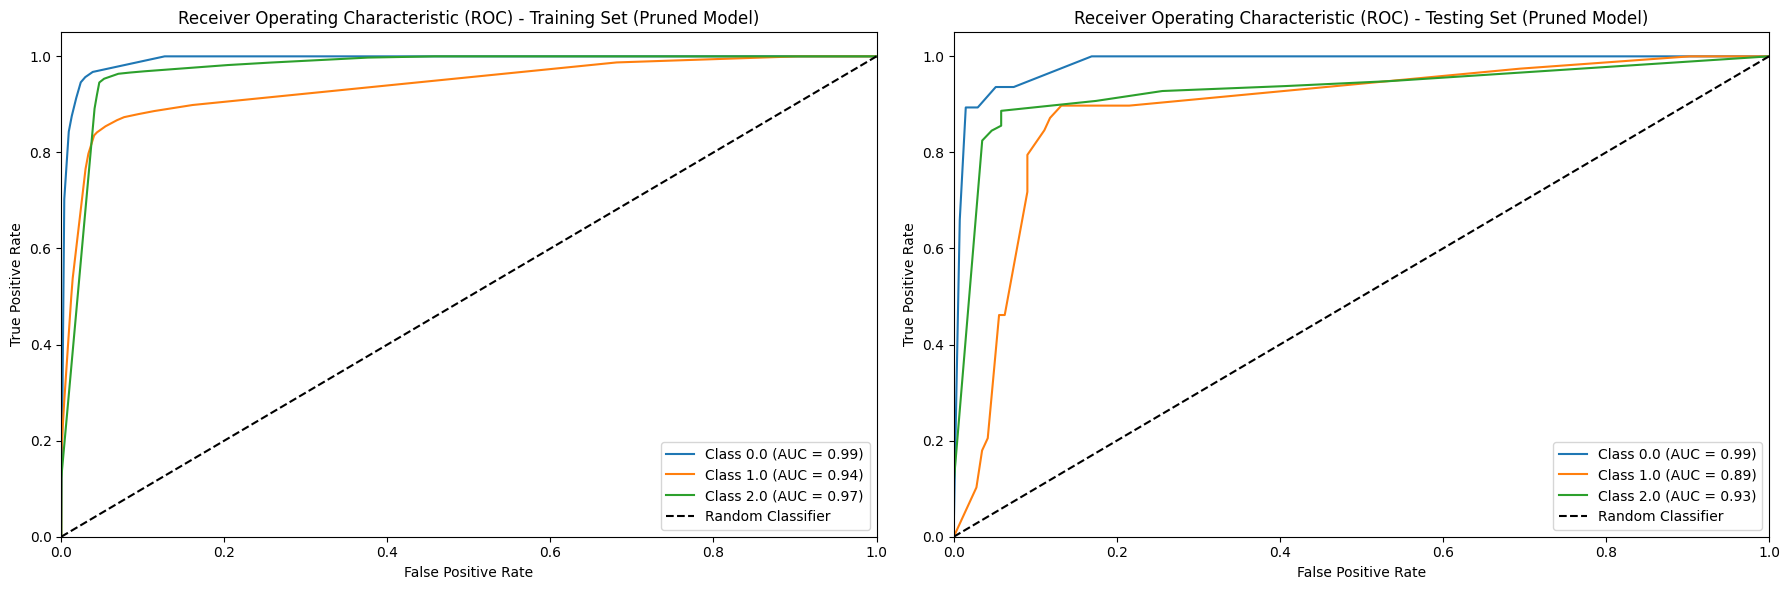

ROC curves and AUC scores plotted for training and testing sets using the pruned model.


In [ ]:
n_classes = len(filtered_safety_order)
class_labels = [str(level) for level in filtered_safety_order]

# Prepare figure for plotting
plt.figure(figsize=(18, 6))

# Plot ROC for Training Set (Pruned Model)
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
for i in range(n_classes):
    y_train_true_class = (y_train == i).astype(int) # True labels for current class
    fpr, tpr, _ = roc_curve(y_train_true_class, y_train_proba_pruned[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Set (Pruned Model)')
plt.legend(loc='lower right')

# Plot ROC for Testing Set (Pruned Model)
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
for i in range(n_classes):
    y_test_true_class = (y_test == i).astype(int) # True labels for current class
    fpr, tpr, _ = roc_curve(y_test_true_class, y_test_proba_pruned[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Testing Set (Pruned Model)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

print("ROC curves and AUC scores plotted for training and testing sets using the pruned model.")

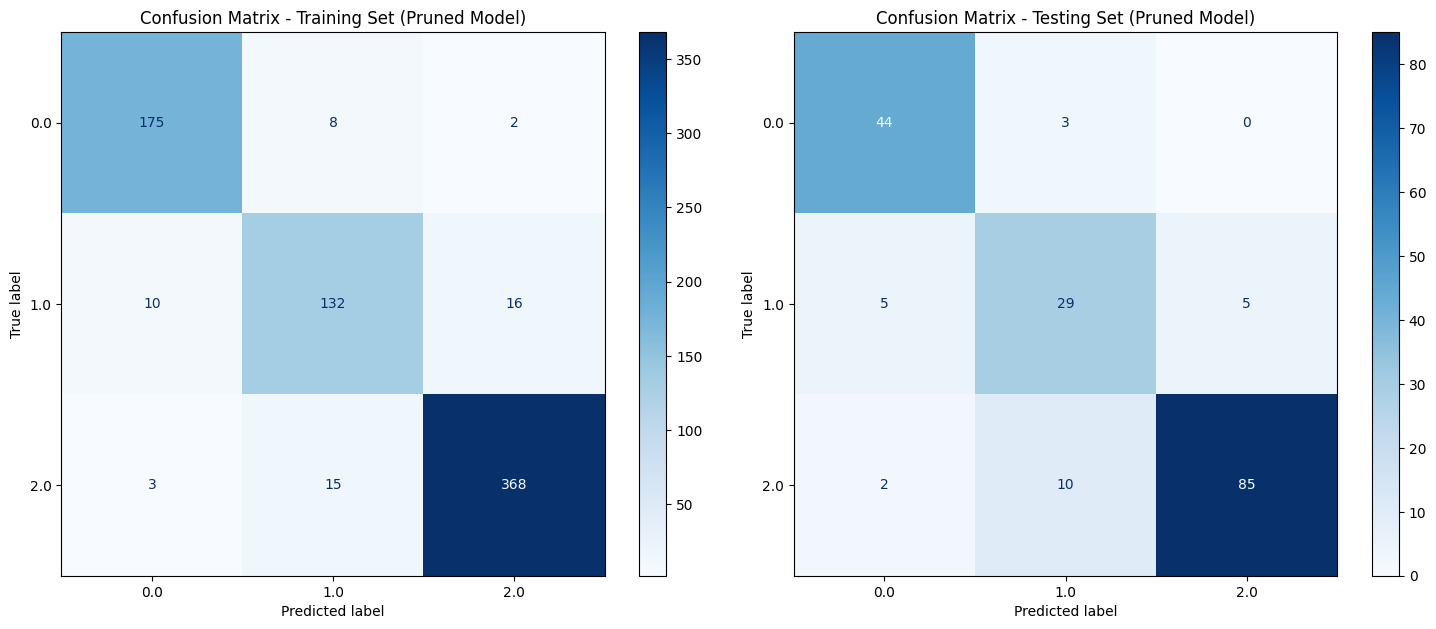

Confusion matrices plotted for training and testing sets using the pruned model.


In [ ]:
plt.figure(figsize=(15, 6))

# Plot Confusion Matrix for Training Set (Pruned Model)
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_pruned, display_labels=class_labels, cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix - Training Set (Pruned Model)')

# Plot Confusion Matrix for Testing Set (Pruned Model)
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_pruned, display_labels=class_labels, cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix - Testing Set (Pruned Model)')

plt.tight_layout()
plt.show()

print("Confusion matrices plotted for training and testing sets using the pruned model.")

In [ ]:
from sklearn.metrics import classification_report

print("\nClassification Report - Training Set (Pruned Model):")
print(classification_report(y_train, y_train_pred_pruned, target_names=class_labels))



Classification Report - Training Set (Pruned Model):
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       185
         1.0       0.85      0.84      0.84       158
         2.0       0.95      0.95      0.95       386

    accuracy                           0.93       729
   macro avg       0.91      0.91      0.91       729
weighted avg       0.93      0.93      0.93       729



In [ ]:
print("\nClassification Report - Testing Set (Pruned Model):")
print(classification_report(y_test, y_test_pred_pruned, target_names=class_labels))


Classification Report - Testing Set (Pruned Model):
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90        47
         1.0       0.69      0.74      0.72        39
         2.0       0.94      0.88      0.91        97

    accuracy                           0.86       183
   macro avg       0.83      0.85      0.84       183
weighted avg       0.87      0.86      0.87       183

